###  Imports

In [11]:
import numpy as np
import pickle
import tqdm
import matplotlib.pyplot as plt

### Data 

In [63]:
class myDataset:
    def __init__(self, data):
        self.data = data
    
    def __iter__(self):
        for i in range(0, self.data.shape[0]):
            yield self.data[i, :]
            
    def __len__(self):
        return self.data.shape[0]
            
    def getX(self):
        return self.data[:, :-1]
    
    def getY(self):
        return self.data[:, -1]


class CVdataloader:
    def __init__(self, cv, datapath, filename):
        self.cv = cv
        self.datapath = datapath
        self.filename = filename
        self.data = pickle.load(open(datapath + "/" + filename, "rb"))[:, :-1]
        self.userNum = len(np.unique(self.data[:, 0]))
        self.movieNum = len(np.unique(self.data[:, 1]))
        self.seperates = list(range(0, self.data.shape[0], int((self.data.shape[0]-1)/self.cv)))
        self.seperates[-1] = self.data.shape[0]
        
    def __iter__(self):
        """
        return train dataset, test dataset for a cv round
        """
        for i in range(self.cv):
            testData = self.data[self.seperates[i]:self.seperates[i+1], :]
            trainData = np.vstack([self.data[0:self.seperates[i], :], self.data[self.seperates[i+1]:, :]])
            yield myDataset(trainData), myDataset(testData)

### Model

In [98]:
class classifier:
    def __init__(self, dim, userNum, movieNum, epoch, lr):
        self.dim = dim
        self.epoch = epoch
        self.lr = lr
        self.userNum = userNum
        self.movieNum = movieNum
        self.userW = np.abs(np.random.randn(userNum, dim)) * 0.01
        self.movieW = np.abs(np.random.randn(movieNum, dim)) * 0.01
    
    def train(self, dataset: myDataset) -> list:
        """
        input: train dataset
        return: loss history by epoch as a list
        """
        loss_history = []
        for i in tqdm.tqdm_notebook(range(self.epoch)):
            preds = []
            for batch_ind, (userInd, movieInd, rating) in enumerate(dataset):
                userInd, movieInd = int(userInd), int(movieInd)
                pred = self.predict(userInd, movieInd)
                preds.append(pred)
                userG = 2 * lr * (rating - pred) * self.movieW[movieInd, :]
                movieG = 2 * lr * (rating - pred) * self.userW[userInd, :]
                self.userW[userInd, :] += userG
                self.movieW[movieInd, :] += movieG
            loss_history.append(self.calc_loss(dataset.getY().flatten(), np.array(preds)).sum() / len(dataset))
        return loss_history
                    
    def predict(self, userInd, movieInd):
        """
        make prediction for one sample
        """
        return np.dot(self.userW[userInd, :], self.movieW[movieInd, :].T)
    
    def evaluate(self, dataset: myDataset) -> float:
        """
        input: test dataset
        output: loss sum on current test set
        """
        loss_sum = 0
        for userInd, movieInd, rating in dataset:
            userInd, movieInd = int(userInd), int(movieInd)
            pred = self.predict(userInd, movieInd)
            loss_sum += self.calc_loss(rating, pred)
        return loss_sum / len(dataset)
    
    @staticmethod
    def calc_loss(true, pred):
        return (true - pred) ** 2

### Scripts

In [79]:
dim = 10
cv = 3
epoch = 10
lr = 0.01
datapath = "/media/zzhuang/00091EA2000FB1D0/iGit/git_projects/RecommendML/data"
filename = "movie_ratings_nudged"
figpath = ""

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


----------------------CV 1-----------------------
loss avg: 13.636749


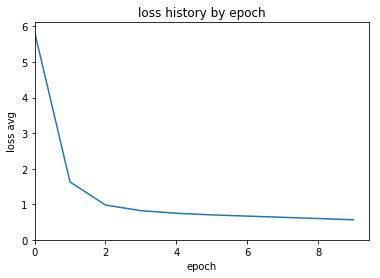

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


----------------------CV 2-----------------------
loss avg: 13.000120


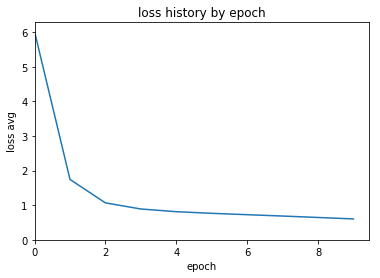

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


----------------------CV 3-----------------------
loss avg: 12.717573


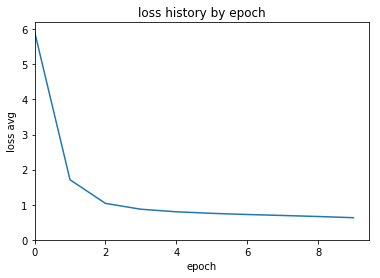

----------------------summary-----------------------
CV loss avg list: [13.63674919570715, 13.000119660713077, 12.717573149649999]


In [99]:
data_loader = CVdataloader(cv, datapath, filename)
loss_avg_list = []
for cvRound, (trainData, validData) in enumerate(data_loader):
    model = classifier(dim, data_loader.userNum, data_loader.movieNum, epoch, lr)
    loss_history = model.train(trainData)
    loss_avg_list.append(model.evaluate(validData))
    print("----------------------CV %d-----------------------" % (cvRound+1))
    print("loss avg: %f" % loss_avg_list[-1])
    plt.plot(range(len(loss_history)), loss_history)
    plt.xlabel("epoch")
    plt.xlim(xmin=0)
    plt.ylabel("loss avg")
    plt.ylim(ymin=0)
    plt.title("loss history by epoch")
    plt.show()

print("----------------------summary-----------------------" )
print("CV loss avg list:", loss_avg_list)